In [1]:
import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data_loader import load_aligned_prices
from src.returns import compute_returns
from src.volatility import rolling_annualized_vol
from src.drawdowns import compute_drawdowns
from src.stress_metrics import (
    compute_spx_vol_threshold,
    label_turbulence,
    compute_sensitivity_score
)
from src.vol_forecast import train_test_split, fit_ar1_forecast, evaluate_forecast
from src.vol_ml import fit_lag_regression
from src.correlations import rolling_vol_correlation

plt.style.use("default")


In [3]:
prices = load_aligned_prices(
    "../data/Nifty 50 Historical Data.csv",
    "../data/S&P 500 Historical Data.csv",
    "../data/FTSE 100 Historical Data.csv"
)

returns = compute_returns(prices)
returns.head()



,NIFTY 50,S&P 500,FTSE 100
Date,,,
2025-12-30,-0.007300,0.007412,0.000939
2025-12-29,0.000125,0.001378,-0.007462
2025-12-24,0.007709,0.003810,0.000421
2025-12-23,0.001341,-0.003211,0.001878
2025-12-22,-0.000181,-0.004530,-0.002351


In [4]:
vol = rolling_annualized_vol(returns, window=30)
vol.head()


,NIFTY 50,S&P 500,FTSE 100
Date,,,
2025-12-30,NaN,NaN,NaN
2025-12-29,NaN,NaN,NaN
2025-12-24,NaN,NaN,NaN
2025-12-23,NaN,NaN,NaN
2025-12-22,NaN,NaN,NaN


In [5]:
drawdowns = compute_drawdowns(prices)
drawdowns.head()


,NIFTY 50,S&P 500,FTSE 100
Date,,,
2025-12-31,0.000000,0.000000,0.000000
2025-12-30,-0.007300,0.000000,0.000000
2025-12-29,-0.007176,0.000000,-0.007462
2025-12-24,0.000000,0.000000,-0.007045
2025-12-23,0.000000,-0.003211,-0.005180


In [6]:
spx_vol = vol["S&P 500"]

threshold = compute_spx_vol_threshold(spx_vol, percentile=80)
turbulence = label_turbulence(spx_vol, threshold)

print("Threshold:", threshold)
print("Turbulent days:", turbulence.sum())


Threshold: 0.22584941032810116
Turbulent days: 276


In [7]:
sens_nifty = compute_sensitivity_score(vol["NIFTY 50"], spx_vol, turbulence)
sens_ftse = compute_sensitivity_score(vol["FTSE 100"], spx_vol, turbulence)

print("NIFTY sensitivity:", sens_nifty)
print("FTSE sensitivity:", sens_ftse)


NIFTY sensitivity: 0.7971179346123795
FTSE sensitivity: 0.7378047219991432


In [8]:
train_vol, test_vol = train_test_split(vol)

params, preds = fit_ar1_forecast(train_vol["S&P 500"], test_vol["S&P 500"])
rmse, mae = evaluate_forecast(test_vol["S&P 500"], preds)

print("AR(1) params (alpha, beta):", params)
print("RMSE:", rmse)
print("MAE:", mae)

print("Train range:", train_vol.index.min(), "→", train_vol.index.max())
print("Test range:", test_vol.index.min(), "→", test_vol.index.max())


AR(1) params (alpha, beta): (np.float64(0.0008211065162024952), np.float64(0.9956206925317159))
RMSE: 0.014101931446119854
MAE: 0.0051142512713333865
Train range: 2020-01-02 00:00:00 → 2024-12-31 00:00:00
Test range: 2025-01-02 00:00:00 → 2025-12-30 00:00:00


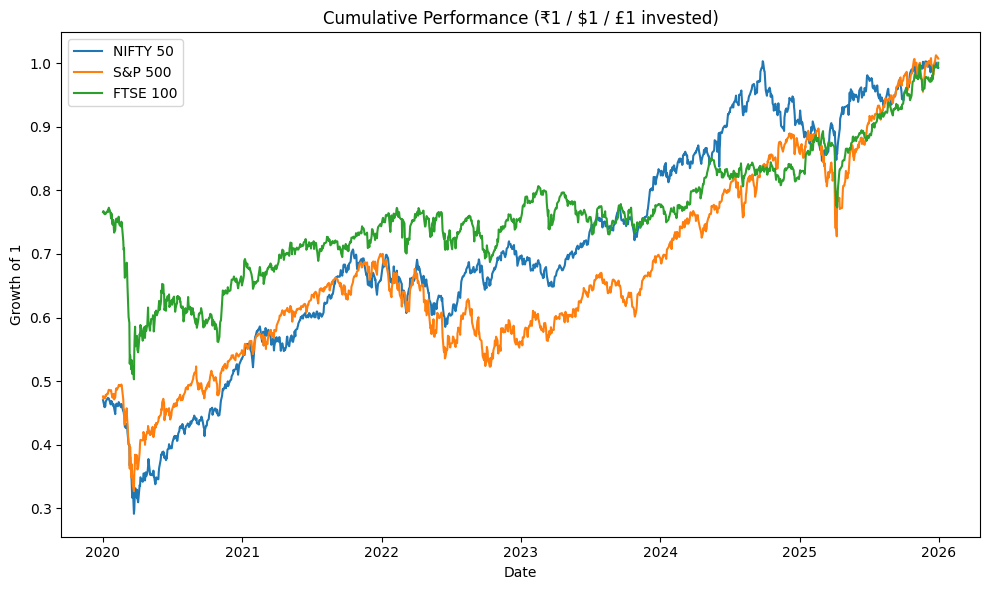

In [9]:
cum_perf = (1 + returns).cumprod()

plt.figure(figsize=(10, 6))
for col in cum_perf.columns:
    plt.plot(cum_perf.index, cum_perf[col], label=col)

plt.title("Cumulative Performance (₹1 / $1 / £1 invested)")
plt.xlabel("Date")
plt.ylabel("Growth of 1")
plt.legend()
plt.tight_layout()

plt.savefig("../outputs/cumulative_performance.png", dpi=200)
plt.show()


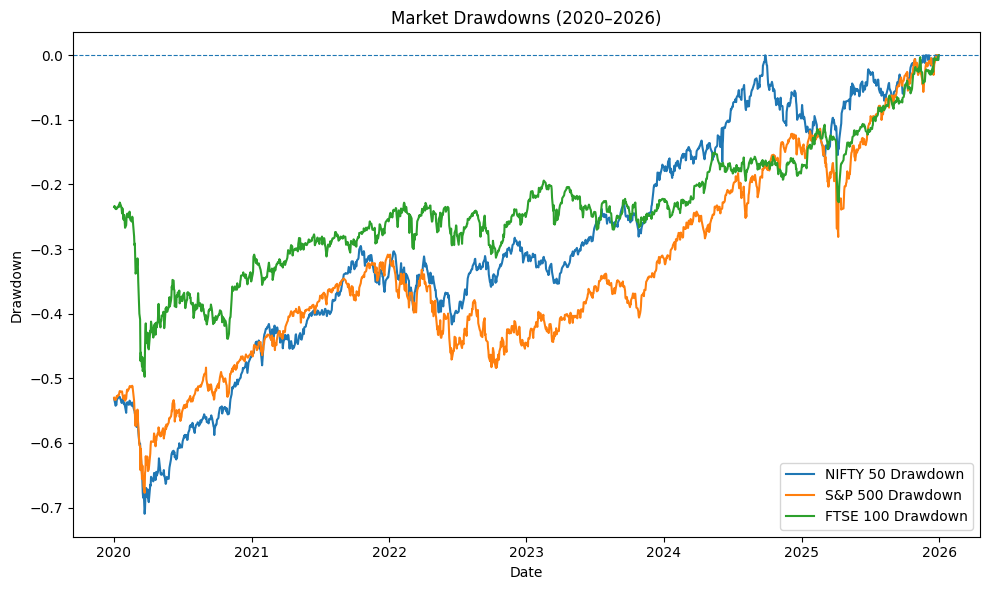

In [11]:
plt.figure(figsize=(10, 6))
for col in drawdowns.columns:
    plt.plot(drawdowns.index, drawdowns[col], label=f"{col} Drawdown")

plt.axhline(0, linestyle="--", linewidth=0.8)
plt.title("Market Drawdowns (2020–2026)")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.tight_layout()

plt.savefig("../outputs/drawdowns.png", dpi=200)
plt.show()


In [12]:
summary = pd.DataFrame({
    "Mean return": returns.mean() * 252,
    "Mean volatility": vol.mean(),
    "Max drawdown": drawdowns.min(),
    "Sharpe ratio": (returns.mean() * 252) / vol.mean()
})

summary.to_csv("../outputs/summary_stats.csv")
summary


,Mean return,Mean volatility,Max drawdown,Sharpe ratio
NIFTY 50,-0.117461,0.157727,-0.709710,-0.744713
S&P 500,-0.110114,0.182451,-0.677238,-0.603526
FTSE 100,-0.032660,0.149223,-0.497632,-0.218868


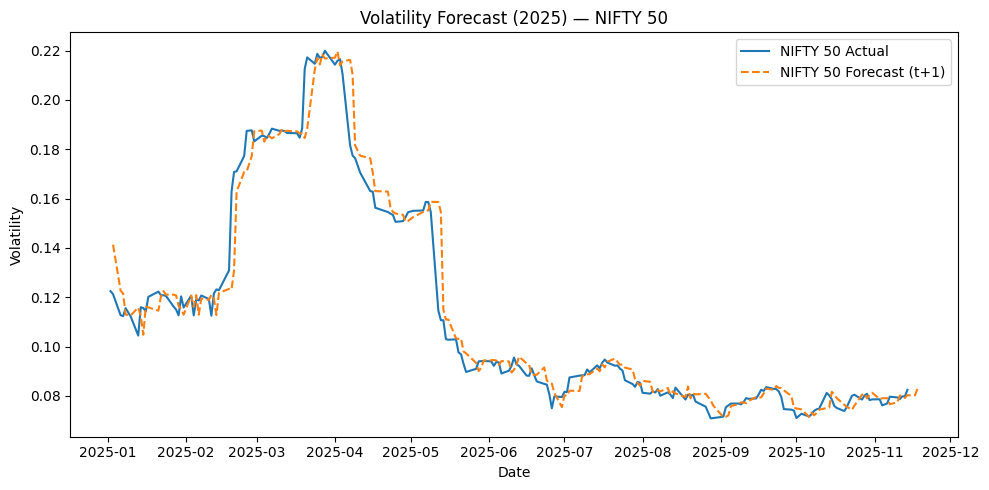

Saved: ../outputs/vol_forecast_2025_NIFTY_50.png


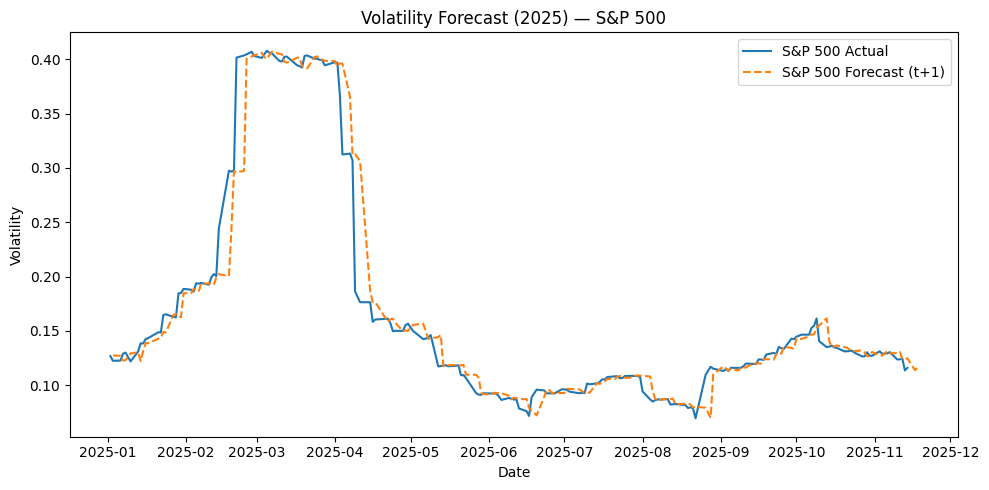

Saved: ../outputs/vol_forecast_2025_S&P_500.png


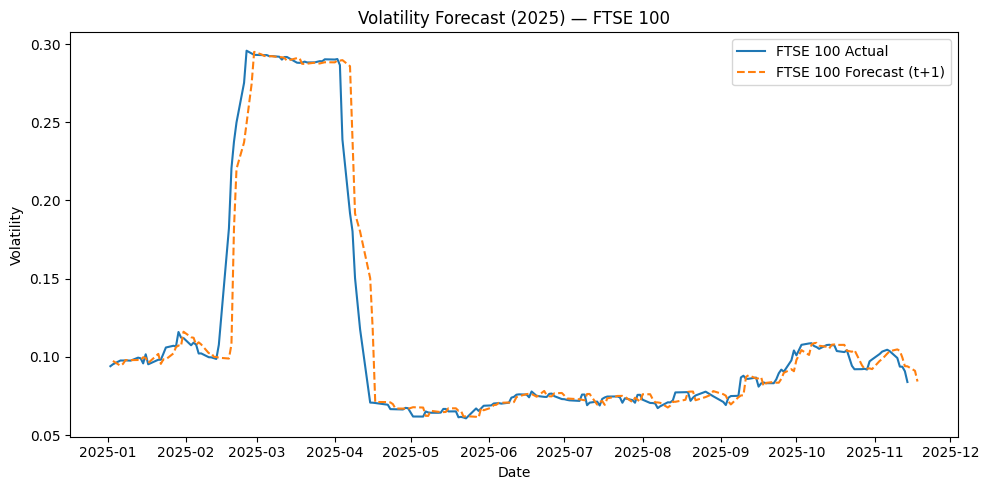

Saved: ../outputs/vol_forecast_2025_FTSE_100.png


In [47]:
train_vol, test_vol = train_test_split(vol)

markets = ["NIFTY 50", "S&P 500", "FTSE 100"]

for market in markets:

    params, raw_preds = fit_ar1_forecast(train_vol[market], test_vol[market])

    # Shift predictions forward by one day to make them truly "t+1" forecasts
    preds = raw_preds.shift(1)

    plt.figure(figsize=(10, 5))

    plt.plot(test_vol.index, test_vol[market], label=f"{market} Actual")
    plt.plot(test_vol.index, preds, linestyle="--", label=f"{market} Forecast (t+1)")

    plt.title(f"Volatility Forecast (2025) — {market}")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.tight_layout()

    fname = f"../outputs/vol_forecast_2025_{market.replace(' ', '_')}.png"
    plt.savefig(fname, dpi=200)
    plt.show()

    print(f"Saved: {fname}")


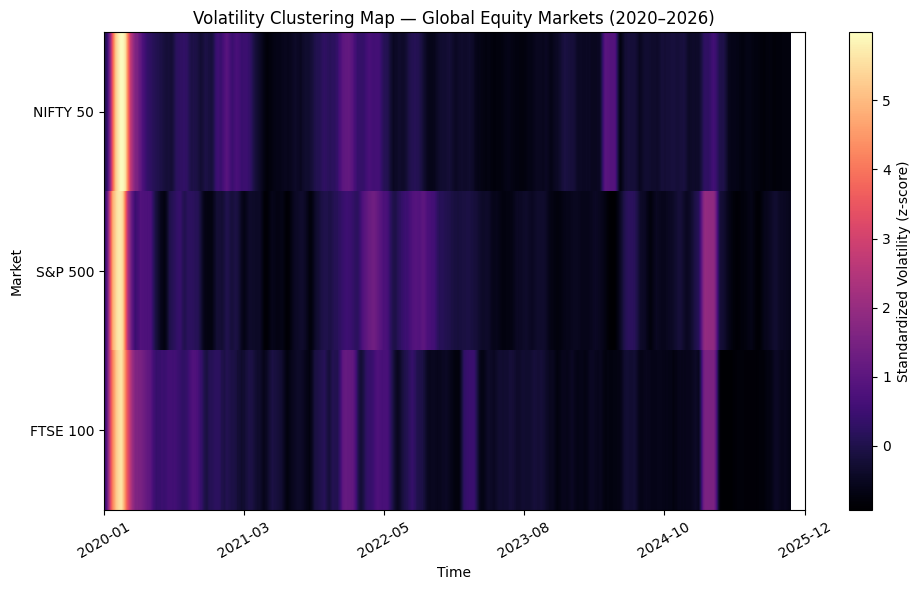

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ---- Prepare data ----
vol_map = vol.copy()

# Smooth slightly to highlight clustering (industry-standard trick)
vol_map = vol_map.rolling(10, min_periods=1).mean()

# Standardize for comparability across markets
vol_z = (vol_map - vol_map.mean()) / vol_map.std()

# Keep full sample (2020–2026)
vol_z = vol_z.sort_index()

# Convert to matrix for plotting
X = vol_z.T.values   # shape: (3 markets × T days)

# ---- Plot ----
plt.figure(figsize=(10, 6))

plt.imshow(
    X,
    aspect="auto",
    cmap="magma",
    interpolation="nearest"
)

plt.yticks([0,1,2], ["NIFTY 50", "S&P 500", "FTSE 100"])

# Smart x-axis ticks (6 evenly spaced dates)
idx = vol_z.index
ticks = np.linspace(0, len(idx)-1, 6).astype(int)
plt.xticks(ticks, pd.to_datetime(idx[ticks]).strftime("%Y-%m"), rotation=30)

plt.colorbar(label="Standardized Volatility (z-score)")
plt.title("Volatility Clustering Map — Global Equity Markets (2020–2026)")
plt.xlabel("Time")
plt.ylabel("Market")

plt.tight_layout()
plt.savefig("../outputs/volatility_clustering_map.png", dpi=200)
plt.show()


In [54]:
# ---- FIX TIME ORDER + CLEAN NA ----
vol = vol.sort_index()        # ensure oldest → newest
vol = vol.dropna()            # remove initial rolling-window NaNs

print("After fix:")
print(vol.head())
print(vol.tail())


After fix:
            NIFTY 50   S&P 500  FTSE 100
Date                                    
2020-01-02  0.149502  0.116436  0.131234
2020-01-03  0.151651  0.114458  0.131093
2020-01-06  0.144391  0.114699  0.134031
2020-01-07  0.144161  0.115070  0.134173
2020-01-08  0.156752  0.177745  0.174356
            NIFTY 50   S&P 500  FTSE 100
Date                                    
2025-11-10  0.079384  0.123622  0.099255
2025-11-11  0.078712  0.123805  0.093730
2025-11-12  0.079805  0.124395  0.093651
2025-11-13  0.079807  0.113557  0.090778
2025-11-14  0.082476  0.115960  0.083880


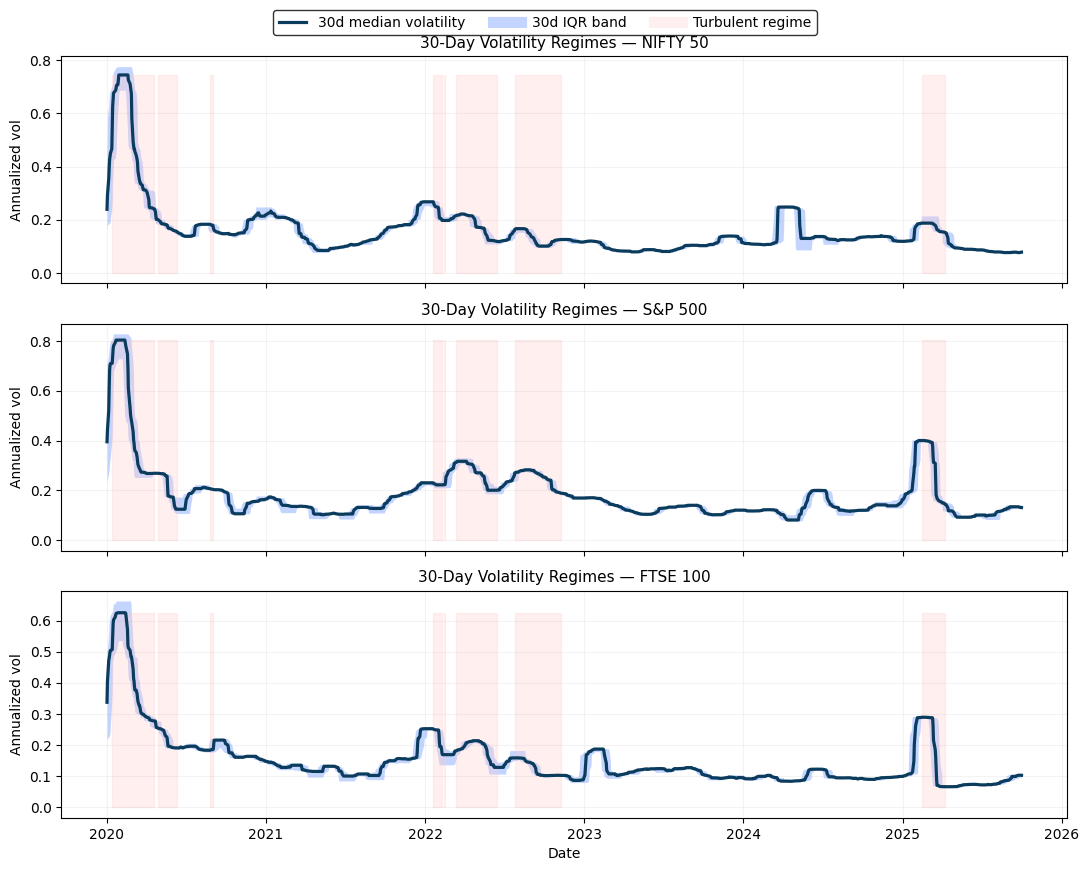

In [58]:
# ============================================================
# HIGH-CONTRAST 30-DAY VOLATILITY REGIME PLOT (ALL MARKETS)
# ============================================================

import matplotlib.pyplot as plt
import pandas as pd

# -----------------------
# RECREATE DATA SAFELY
# -----------------------
prices = load_aligned_prices(
    "../data/Nifty 50 Historical Data.csv",
    "../data/S&P 500 Historical Data.csv",
    "../data/FTSE 100 Historical Data.csv"
)

returns = compute_returns(prices)
vol = rolling_annualized_vol(returns, window=30).dropna()

# turbulence labels from your S&P rule
threshold = compute_spx_vol_threshold(vol["S&P 500"])
turb = label_turbulence(vol, threshold)["S&P 500"]

# -----------------------
# STRONGER, PROFESSIONAL COLORS
# -----------------------
MAIN_LINE = "#0b3c5d"      # deep navy
IQR_BAND = "#7aa1ff"       # brighter blue
TURB_BAND = "#ffcccc"      # soft but visible red

markets = ["NIFTY 50", "S&P 500", "FTSE 100"]

fig, axes = plt.subplots(3, 1, figsize=(11, 9), sharex=True)

for ax, m in zip(axes, markets):

    v = vol[[m]].copy()

    # 30-day distribution bands
    v["p25"] = v[m].rolling(30).quantile(0.25)
    v["p75"] = v[m].rolling(30).quantile(0.75)
    v["median"] = v[m].rolling(30).median()

    # ---- IQR band (much clearer now) ----
    ax.fill_between(
        v.index,
        v["p25"],
        v["p75"],
        color=IQR_BAND,
        alpha=0.45,        # stronger opacity
        linewidth=0
    )

    # ---- median vol ----
    ax.plot(
        v.index,
        v["median"],
        color=MAIN_LINE,
        linewidth=2.3
    )

    # ---- turbulent regimes (now clearly visible) ----
    ax.fill_between(
        v.index,
        0,
        v["median"].max(),
        where=(turb.reindex(v.index, method="ffill") == 1),
        color=TURB_BAND,
        alpha=0.30
    )

    ax.set_title(f"30-Day Volatility Regimes — {m}", fontsize=11)
    ax.set_ylabel("Annualized vol")
    ax.grid(alpha=0.15)

axes[-1].set_xlabel("Date")

# -----------------------
# CLEAR, READABLE LEGEND
# -----------------------
handles = [
    plt.Line2D([0], [0], color=MAIN_LINE, lw=2.3,
               label="30d median volatility"),
    plt.Line2D([0], [0], color=IQR_BAND, lw=8, alpha=0.45,
               label="30d IQR band"),
    plt.Line2D([0], [0], color=TURB_BAND, lw=8, alpha=0.30,
               label="Turbulent regime"),
]

fig.legend(
    handles=handles,
    loc="upper center",
    ncol=3,
    frameon=True,
    facecolor="white",
    edgecolor="black",
    fontsize=10,
    bbox_to_anchor=(0.5, 0.97)
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

fig.savefig(
    "../outputs/volatility_regimes_30d_high_contrast.png",
    dpi=220,
    bbox_inches="tight"
)


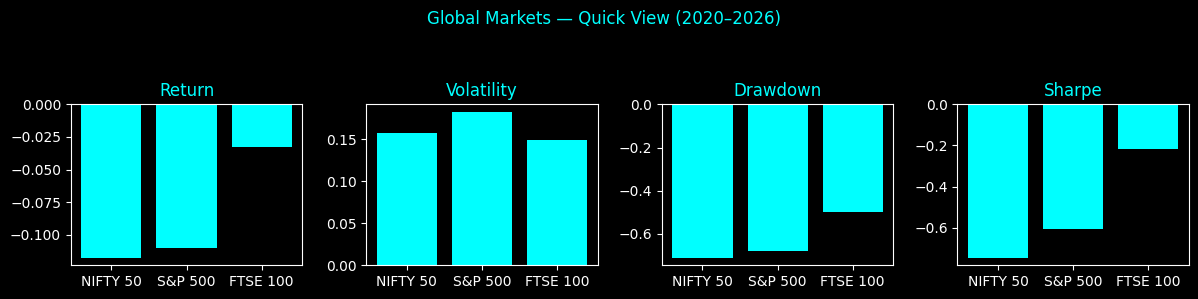

In [70]:
# ---------------- BLOOMBERG TILE STYLE ----------------
import pandas as pd
import matplotlib.pyplot as plt

prices = load_aligned_prices(
    "../data/Nifty 50 Historical Data.csv",
    "../data/S&P 500 Historical Data.csv",
    "../data/FTSE 100 Historical Data.csv"
)

returns = compute_returns(prices)
vol = rolling_annualized_vol(returns, 30).dropna()
drawdowns = compute_drawdowns(prices)

summary = pd.DataFrame({
    "Return": returns.mean()*252,
    "Volatility": vol.mean(),
    "Drawdown": drawdowns.min(),
    "Sharpe": (returns.mean()*252)/vol.mean()
})

plt.style.use("dark_background")

fig, axes = plt.subplots(1,4, figsize=(12,3))
fig.suptitle("Global Markets — Quick View (2020–2026)", color="cyan")

metrics = ["Return","Volatility","Drawdown","Sharpe"]

for ax, m in zip(axes, metrics):
    ax.bar(summary.index, summary[m], color="#00ffff")
    ax.set_title(m, color="cyan")
    ax.tick_params(colors="white")

plt.tight_layout(rect=[0,0,1,0.9])
plt.savefig("../outputs/bloomberg_tiles.png", dpi=300, bbox_inches="tight")
plt.show()
